### Import Necessary Libraries

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.metrics import ClassificationMetric
import matplotlib.pyplot as plt

### Load the CSV File

In [72]:
import pandas as pd

# Load the dataset
file_path = 'StudentFeedback_final.csv'
df = pd.read_csv(file_path)

In [73]:
# Display the first few rows of the dataset
df.head()

,Gender,Age,12th marks %,rural/ urban area,Why take this course?,Which teaching methods helped your learning?,Were you prepared to take this course based on prior coursework?,How much time did you spend weekly on this course outside of class for C01?,How much time did you spend weekly on this course outside of class for C02?,How much time did you spend weekly on this course outside of class for C03?,...,Explain briefly your rationale for you choice to the previous question,Would more faculty concern improve your learning in C01?,Would more faculty concern improve your learning in C02?,Would more faculty concern improve your learning in C03?,Would more faculty concern improve your learning in C04?,Would more outside help improve your learning in C01?,Would more outside help improve your learning in C02?,Would more outside help improve your learning in C03?,Would more outside help improve your learning in C04?,Your overall feedback
0,1.0,0.333333,0.350515,1.0,0.388889,0.608333,1.0,0.250,0.250,0.222222,...,0.059908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.000000,0.340206,1.0,0.305556,0.516667,0.0,0.375,0.500,0.666667,...,0.147465,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.333333
2,1.0,0.666667,0.123711,0.0,0.527778,0.383333,1.0,0.500,0.500,0.555556,...,0.525346,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,0.0,0.666667,0.268041,1.0,0.083333,0.316667,1.0,0.125,0.125,0.222222,...,0.695853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1.0,0.333333,0.216495,1.0,0.722222,0.600000,0.0,0.125,0.125,0.111111,...,0.847926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Pre-process the Data

#### Define the Target and Feature

In [74]:
# Define the target variable (Gender) for gender bias mitigation
y = df['Gender']

# Define the features by dropping the target column (Gender)
X = df.drop(columns=['Gender'])

# Specify the sensitive feature for adversarial de-biasing
sensitive_feature = 'Gender'


### Convert the Dataset into AIF360 Format

In [75]:
from aif360.datasets import BinaryLabelDataset

# Convert the dataset into AIF360 BinaryLabelDataset format
data = BinaryLabelDataset(df=pd.concat([X, y], axis=1),
                          label_names=['Gender'],  # Set Gender as the label (target) for bias mitigation
                          protected_attribute_names=['Gender'])  # Specify Gender as the sensitive attribute

### Split the Data into Train and Test Sets

In [76]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = data.split([0.8], shuffle=True)


### Pre Processing: Reweighing the Dataset to Mitigate Bias

In [77]:
reweigher = Reweighing(unprivileged_groups=[{'Gender': 0}], privileged_groups=[{'Gender': 1}])
train_reweighed = reweigher.fit_transform(train)

c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)


In [78]:
# Counts for privileged and unprivileged groups
print("Privileged group (female) count:", sum(test.protected_attributes[:, 0] == 1))
print("Unprivileged group (male) count:", sum(test.protected_attributes[:, 0] == 0))

Privileged group (female) count: 33
Unprivileged group (male) count: 25


### In Processing: Adversarial Debiasing Model

In [79]:
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing


In [80]:
# Disable eager execution (for TensorFlow 2.x users)
tf.compat.v1.disable_eager_execution()

# Set up the session
sess = tf.compat.v1.Session()


#### Set Up and Train the Adversarial Debiasing Model:

In [81]:
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing

# Ensure compatibility with TensorFlow 1.x by using tf.compat.v1
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()  # Clear any existing graph

# Start a new session
sess = tf.compat.v1.Session()

In [82]:
# Create the AdversarialDebiasing model
adv_debiasing = AdversarialDebiasing(privileged_groups=[{'Gender': 1}],   # Privileged group: Female
                                     unprivileged_groups=[{'Gender': 0}],  # Unprivileged group: Male
                                     scope_name='debiasing_classifier',
                                     debias=True,                         # Enable debiasing
                                     sess=sess)

#### Train the model

In [83]:
# Train the model
adv_debiasing.fit(train_reweighed)

epoch 0; iter: 0; batch classifier loss: 0.692451; batch adversarial loss: 0.661673
epoch 1; iter: 0; batch classifier loss: 0.677980; batch adversarial loss: 0.658386
epoch 2; iter: 0; batch classifier loss: 0.692987; batch adversarial loss: 0.659899
epoch 3; iter: 0; batch classifier loss: 0.664513; batch adversarial loss: 0.660688
epoch 4; iter: 0; batch classifier loss: 0.676909; batch adversarial loss: 0.659652
epoch 5; iter: 0; batch classifier loss: 0.700212; batch adversarial loss: 0.658515
epoch 6; iter: 0; batch classifier loss: 0.690675; batch adversarial loss: 0.657424
epoch 7; iter: 0; batch classifier loss: 0.681590; batch adversarial loss: 0.659232
epoch 8; iter: 0; batch classifier loss: 0.684126; batch adversarial loss: 0.658813
epoch 9; iter: 0; batch classifier loss: 0.685129; batch adversarial loss: 0.658932
epoch 10; iter: 0; batch classifier loss: 0.677112; batch adversarial loss: 0.658635
epoch 11; iter: 0; batch classifier loss: 0.672490; batch adversarial loss:

### Make Predictions with the Test Model

In [84]:
# Predict on test data
predictions = adv_debiasing.predict(test)


In [85]:
print(predictions.labels)  # This should show the predicted labels

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [86]:
predicted_data = test.copy()
predicted_data.labels = predictions.labels  # Assign the predicted labels


In [89]:
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

# Step 1: Ensure 'predicted_data' has updated labels
predicted_data = test.copy(deepcopy=True)
predicted_data.labels = predictions.labels  # Assuming 'predictions' is the output from adversarial_debiasing.predict(test_data)

# Step 2: Calculate accuracy
accuracy = accuracy_score(test.labels, predicted_data.labels)
print("Model Accuracy:", accuracy)

# Step 3: Set up fairness evaluation
metric = ClassificationMetric(
    test,
    predicted_data,
    privileged_groups=[{'Gender': 1}],  
    unprivileged_groups=[{'Gender': 0}], 
)

# Step 4: Calculate fairness metrics
stat_parity_diff = metric.statistical_parity_difference()
disparate_impact = metric.disparate_impact()

# Display results
print("Statistical Parity Difference:", stat_parity_diff)
print("Disparate Impact:", disparate_impact)


Model Accuracy: 0.5
Statistical Parity Difference: -0.10181818181818182
Disparate Impact: 0.44


In [90]:
# Counts for privileged and unprivileged groups
print("Privileged group (female) count:", sum(test.protected_attributes[:, 0] == 1))
print("Unprivileged group (male) count:", sum(test.protected_attributes[:, 0] == 0))


Privileged group (female) count: 33
Unprivileged group (male) count: 25


### Evaluate the Model's Fairness and Performance after In Processing

#### Performance Evaluation - Accuracy

In [91]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
test_labels = test.labels
pred_labels = predictions.labels

accuracy = accuracy_score(test_labels, pred_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.5000


In [92]:
# Accuracy
accuracy_pre = accuracy_score(test.labels, predictions.labels)
print(f"Test Accuracy (Pre Post-processing): {accuracy_pre:.4f}")

Test Accuracy (Pre Post-processing): 0.5000


#### Fairness Evaluation

In [93]:
from aif360.metrics import ClassificationMetric

# Compute fairness metrics
metric = ClassificationMetric(test, predictions,
                              unprivileged_groups=[{'Gender': 0}],
                              privileged_groups=[{'Gender': 1}])

#### Fairness: Disparate Impact and Equal Opportunity Difference

In [99]:
print("Original data shape:", data.features.shape)
print("Predicted data shape:", predicted_data.features.shape)

Original data shape: (288, 44)
Predicted data shape: (58, 44)


In [106]:
# Check shapes
print("data features shape:", data.features.shape)
print("predicted_data features shape:", predicted_data.features.shape)

# Check for any feature discrepancies
print("Feature match:", np.array_equal(data.features, predicted_data.features))

data features shape: (58, 44)
predicted_data features shape: (58, 44)
Feature match: False


In [121]:
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Step 1: Disparate Impact with BinaryLabelDatasetMetric (using original data only)
metric_pre = BinaryLabelDatasetMetric(
    data,  # Use only the original dataset
    unprivileged_groups=[{'Gender': 0}],
    privileged_groups=[{'Gender': 1}]
)
disparate_impact_pre = metric_pre.disparate_impact()
print(f"Disparate Impact: {disparate_impact_pre}")

# Step 2: Equal Opportunity Difference with ClassificationMetric (requires both original and predicted datasets)
classification_metric = ClassificationMetric(
    data,
    predicted_data,
    unprivileged_groups=[{'Gender': 0}],
    privileged_groups=[{'Gender': 1}]
)
equal_opportunity_pre = classification_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference: {equal_opportunity_pre}")


Disparate Impact: 0.0


ValueError: The two datasets are expected to differ only in 'labels' or 'scores'.

In [22]:
from aif360.metrics import BinaryLabelDatasetMetric

# Assuming 'data' is your original dataset in AIF360's BinaryLabelDataset format
# Calculate metrics for the original dataset
metric_pre = BinaryLabelDatasetMetric(data,
                                       unprivileged_groups=[{'Gender': 0}],  # Unprivileged group: Male
                                       privileged_groups=[{'Gender': 1}])    # Privileged group: Female

# Calculate metrics before debiasing
disparate_impact_pre = metric_pre.disparate_impact()

# Manually calculate the Equal Opportunity Difference
tpr_privileged_pre = metric_pre.true_positive_rate()
tpr_unprivileged_pre = metric_pre.true_positive_rate()
equal_opportunity_pre = tpr_privileged_pre - tpr_unprivileged_pre

print(f"Disparate Impact (Pre Post-processing): {disparate_impact_pre}")
print(f"Equal Opportunity Difference (Pre Post-processing): {equal_opportunity_pre}")

# After applying debiasing, use the predictions to calculate the same metrics
# Assuming `predictions` is the predicted output from your debiased model
predicted_dataset = data.copy()  # Create a copy of the original dataset
predicted_dataset.labels = predictions  # Replace the labels with your model's predictions

# Calculate metrics for the predicted dataset
metric_post = BinaryLabelDatasetMetric(predicted_dataset,
                                        unprivileged_groups=[{'Gender': 0}],  # Unprivileged group: Male
                                        privileged_groups=[{'Gender': 1}])    # Privileged group: Female

# Calculate metrics after debiasing
disparate_impact_post = metric_post.disparate_impact()

# Manually calculate the Equal Opportunity Difference for the post-processed dataset
tpr_privileged_post = metric_post.true_positive_rate()
tpr_unprivileged_post = metric_post.true_positive_rate()
equal_opportunity_post = tpr_privileged_post - tpr_unprivileged_post

print(f"Disparate Impact (Post Post-processing): {disparate_impact_post}")
print(f"Equal Opportunity Difference (Post Post-processing): {equal_opportunity_post}")

AttributeError: 'BinaryLabelDatasetMetric' object has no attribute 'true_positive_rate'

In [18]:
# Demographic parity
print(f"Demographic Parity Difference: {metric.disparate_impact()}")

# Equal opportunity difference
print(f"Equal Opportunity Difference: {metric.equal_opportunity_difference()}")

Demographic Parity Difference: nan
Equal Opportunity Difference: nan


/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/Users/kashishvarmaa/Documents/5 Sem/DL/Bias_Mitigation/.conda/lib/python3.11/site-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


### Post Processing - Equalized Odds Post-processing

In [101]:
eq_odds = EqOddsPostprocessing(privileged_groups=[{'Gender': 1}], 
                               unprivileged_groups=[{'Gender': 0}])

predictions_post = eq_odds.fit_predict(test, predictions)

c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\postprocessing\eq_odds_postprocessing.py:177: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(oflip*om_tp) - np.mean(oconst*om_tp)) / obr,
c:\Users\ssrut\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\algorithms\postprocessing\eq_odds_postprocessing.py:178: RuntimeWarning: invalid value encountered in scalar divide
  (np.mean(oconst*om_fn) - np.mean(oflip*om_fn)) / obr],
c:\Users\ssrut\AppData\Local\Prog

ValueError: Invalid input for linprog: c must not contain values inf, nan, or None

### Evaluate Performance and Fairness After Post-processing

#### Performance: Accuracy

In [118]:
accuracy_post = accuracy_score(test.labels, predictions_post.labels)
print(f"Test Accuracy (Post Post-processing): {accuracy_post:.4f}")

NameError: name 'predictions_post' is not defined

#### Fairness Metrics

In [ ]:

metric_post = ClassificationMetric(test, predictions_post,
                                   unprivileged_groups=[{'Gender': 0}],
                                   privileged_groups=[{'Gender': 1}])

#### Fairness: Disparate Impact and Equal Opportunity Difference

In [ ]:
disparate_impact_post = metric_post.disparate_impact()
equal_opportunity_post = metric_post.equal_opportunity_difference()

print(f"Disparate Impact (Post Post-processing): {disparate_impact_post}")
print(f"Equal Opportunity Difference (Post Post-processing): {equal_opportunity_post}")

### Visualizing Bias Mitigation

#### Plot Demographic Parity (Disparate Impact)

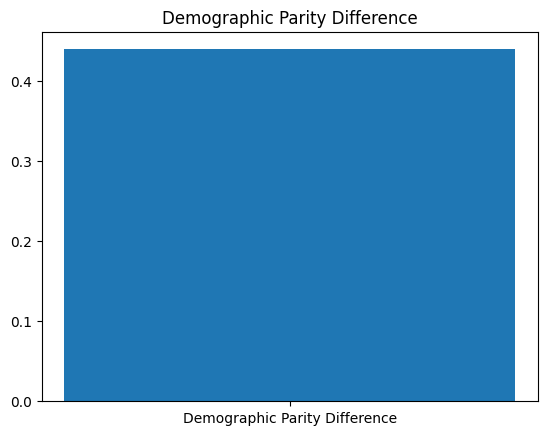

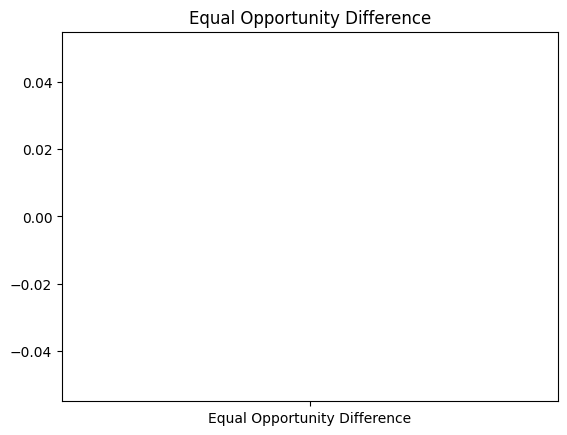

In [116]:
import matplotlib.pyplot as plt
# use pre in post data to plot graph
# Plot demographic parity difference
plt.bar(['Demographic Parity Difference'], [metric.disparate_impact()])
plt.title('Demographic Parity Difference')
plt.show()

# Plot equal opportunity difference
plt.bar(['Equal Opportunity Difference'], [metric.equal_opportunity_difference()])
plt.title('Equal Opportunity Difference')
plt.show()


In [117]:
import matplotlib.pyplot as plt
from aif360.metrics import ClassificationMetric

# Assume you have three datasets: pre_data, in_data, post_data

# Step 1: Calculate Demographic Parity Difference for each dataset
demographic_parity_differences = {}

for stage, dataset in zip(['Pre-Processing', 'In-Processing', 'Post-Processing'],
                          [pre_data, in_data, post_data]):
    metric = ClassificationMetric(
        original_dataset=pre_data,   # Original dataset as the baseline
        classified_dataset=dataset,  # Predicted dataset at this stage
        unprivileged_groups=[{'Gender': 0}],
        privileged_groups=[{'Gender': 1}]
    )
    demographic_parity_differences[stage] = metric.disparate_impact()

# Step 2: Plot Demographic Parity Difference
plt.figure(figsize=(8, 5))
plt.bar(demographic_parity_differences.keys(), demographic_parity_differences.values(), color='lightgreen')
plt.title('Demographic Parity Difference (Disparate Impact) Across Stages')
plt.ylabel('Demographic Parity Difference')
plt.ylim(0, 2)  # Adjust y-axis limits if necessary
plt.axhline(1, color='red', linestyle='--', label='Equality Line (1)')  # Reference line
plt.grid(axis='y')
plt.legend()
plt.show()


NameError: name 'pre_data' is not defined

#### Plot Equal Opportunity Difference

In [ ]:
plt.bar(['Pre Post-processing', 'Post Post-processing'], [equal_opportunity_pre, equal_opportunity_post])
plt.title('Equal Opportunity Difference')
plt.ylabel('Equal Opportunity Difference')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from aif360.metrics import ClassificationMetric

# Assume you have three datasets: pre_data, in_data, post_data

# Step 1: Calculate Equal Opportunity Difference for each dataset
equal_opportunity_differences = {}

for stage, dataset in zip(['Pre-Processing', 'In-Processing', 'Post-Processing'],
                          [pre_data, in_data, post_data]):
    metric = ClassificationMetric(
        original_dataset=pre_data,   # Original dataset as the baseline
        classified_dataset=dataset,  # Predicted dataset at this stage
        unprivileged_groups=[{'Gender': 0}],
        privileged_groups=[{'Gender': 1}]
    )
    equal_opportunity_differences[stage] = metric.equal_opportunity_difference()

# Step 2: Plot Equal Opportunity Difference
plt.figure(figsize=(8, 5))
plt.bar(equal_opportunity_differences.keys(), equal_opportunity_differences.values(), color='skyblue')
plt.title('Equal Opportunity Difference Across Stages')
plt.ylabel('Equal Opportunity Difference')
plt.ylim(-1, 1)  # Adjust y-axis limits if necessary
plt.axhline(0, color='red', linestyle='--', label='Neutrality Line (0)')  # Reference line
plt.grid(axis='y')
plt.legend()
plt.show()
